# Artificial Neural Networks and Deep Learning

---

## Homework 2: Bio.log(y)

### Model 4: Double U-Net + Transformer Block

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.saving import register_keras_serializable
from tensorflow.keras.layers import UpSampling2D, Concatenate, Conv2D, Activation, Add

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data

In [2]:
# Load the compressed dataset
data = np.load("/kaggle/input/flamethrower/mars_datasets_base.npz")

# Extract the individual arrays
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_our_test = data["X_our_test"]
y_our_test = data["y_our_test"]
X_test = data["X_test"]

# Print shapes to verify successful loading
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_our_test shape: {X_our_test.shape}")
print(f"y_our_test shape: {y_our_test.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1503, 64, 128, 1)
y_train shape: (1503, 64, 128)
X_val shape: (501, 64, 128, 1)
y_val shape: (501, 64, 128)
X_our_test shape: (501, 64, 128, 1)
y_our_test shape: (501, 64, 128)
X_test shape: (10022, 64, 128, 1)


## 🛠️ Train and Save the Model

In [3]:
input_shape = (64, 128, 1)
num_classes = len(np.unique(y_train))

In [4]:
# Number of training epochs
epochs = 200

# Batch size for training
batch_size = 32

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 200
Batch Size: 32


In [5]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    label = np.asarray(label).squeeze()

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [6]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, num_classes, frequency=5):
        super().__init__()
        self.image = image
        self.label = label  # Assumiamo che `label` sia già un array NumPy
        self.num_classes = num_classes
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epoche
            pred = self.model.predict(tf.expand_dims(self.image, axis=0), verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.image.squeeze(), cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(self.label, colormap)  # Rimosso `.numpy()`
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [7]:
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

    # Exclude the background class
    y_true = y_true[..., 1:]
    y_pred = y_pred[..., 1:]

    # Clip predictions
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    # Focal loss
    cross_entropy = -y_true * tf.math.log(y_pred)
    weights = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weights * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

def dice_loss(y_true, y_pred, smooth=1e-6):

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)

    # Exclude the background class
    y_true = y_true[..., 1:]
    y_pred = y_pred[..., 1:]

    # Intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2])

    # Dice loss
    dice = 1 - (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

def combined_loss(y_true, y_pred, dice_weight=0.5, focal_weight=0.5):
    d_loss = dice_loss(y_true, y_pred)
    f_loss = focal_loss(y_true, y_pred)
    return focal_weight * f_loss + dice_weight * d_loss

In [8]:
@register_keras_serializable()  # Optional: Simplifies future model loading
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, name='transformer_block', **kwargs):
        super(TransformerBlock, self).__init__(name=name, **kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=name+'_mha')
        self.ffn = tf.keras.Sequential([
            tfkl.Dense(ff_dim, activation='relu', name=name+'_ffn_dense1'),
            tfkl.Dense(embed_dim, name=name+'_ffn_dense2'),
        ], name=name+'_ffn')
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6, name=name+'_ln1')
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6, name=name+'_ln2')
        self.dropout1 = tfkl.Dropout(rate, name=name+'_dropout1')
        self.dropout2 = tfkl.Dropout(rate, name=name+'_dropout2')

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Residual connection

In [9]:
def residual_block(x, filters, kernel_size=3, activation='relu', name=''):
    """A residual block with two convolutions, batch normalization, and a skip connection."""
    skip = x
    # First convolution
    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name+'conv1')(x)
    x = tfkl.BatchNormalization(name=name+'bn1')(x)
    x = tfkl.Activation(activation, name=name+'act1')(x)

    # Second convolution
    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name+'conv2')(x)
    x = tfkl.BatchNormalization(name=name+'bn2')(x)

    # Adjust skip connection if necessary
    if skip.shape[-1] != filters:
        skip = tfkl.Conv2D(filters, 1, padding='same', name=name+'conv_skip')(skip)

    # Add skip connection
    x = tfkl.Add(name=name+'add')([x, skip])
    x = tfkl.Activation(activation, name=name+'act2')(x)
    return x

In [10]:
def attention_gate(x, g, filters, name=''):
    """An attention gate that highlights relevant features from the skip connection x using the gating signal g."""
    # Project x and g
    x_proj = tfkl.Conv2D(filters, 1, padding='same', name=name+'x_proj')(x)
    g_proj = tfkl.Conv2D(filters, 1, padding='same', name=name+'g_proj')(g)

    # Combine projections
    combined = tfkl.Add(name=name+'add')([x_proj, g_proj])
    combined = tfkl.Activation('relu', name=name+'relu')(combined)

    # Compute attention coefficients
    attn = tfkl.Conv2D(1, 1, padding='same', name=name+'attn_conv')(combined)
    attn = tfkl.Activation('sigmoid', name=name+'attn_sigmoid')(attn)

    # Multiply attention coefficients with the skip connection
    x = tfkl.Multiply(name=name+'attn_mul')([x, attn])
    return x

In [11]:
def multi_scale_bottleneck(x, filters, activation='relu', name=''):
    """Multi-scale context with parallel dilated convolutions."""
    # Dilated convolutions with different rates
    x1 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=1, name=name+'dil1_conv')(x)
    x1 = tfkl.BatchNormalization(name=name+'dil1_bn')(x1)
    x1 = tfkl.Activation(activation, name=name+'dil1_act')(x1)

    x2 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=2, name=name+'dil2_conv')(x)
    x2 = tfkl.BatchNormalization(name=name+'dil2_bn')(x2)
    x2 = tfkl.Activation(activation, name=name+'dil2_act')(x2)

    x3 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=4, name=name+'dil3_conv')(x)
    x3 = tfkl.BatchNormalization(name=name+'dil3_bn')(x3)
    x3 = tfkl.Activation(activation, name=name+'dil3_act')(x3)

    # Concatenate the outputs
    x_cat = tfkl.Concatenate(name=name+'concat')([x1, x2, x3])

    # Compress back to the original number of filters
    x_out = tfkl.Conv2D(filters, 1, padding='same', name=name+'compress_conv')(x_cat)
    x_out = tfkl.BatchNormalization(name=name+'compress_bn')(x_out)
    x_out = tfkl.Activation(activation, name=name+'compress_act')(x_out)

    return x_out

In [12]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import UpSampling2D, Concatenate, Conv2D, Activation, Add

def get_double_unet_with_transformer(input_shape=(64,128,1), num_classes=5, activation='relu', seed=42):
    """
    Builds a Double U-Net model with Transformer Blocks, using concatenation for fusion.
    """
    if seed is not None:
        tf.random.set_seed(seed)

    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    # First U-Net Path (Detailed)
    # Encoder
    f1_1 = residual_block(inputs, 64, name='enc1_1_')
    p1_1 = tfkl.MaxPooling2D((2,2), name='pool1_1')(f1_1)

    f2_1 = residual_block(p1_1, 128, name='enc2_1_')
    p2_1 = tfkl.MaxPooling2D((2,2), name='pool2_1')(f2_1)

    # Bottleneck
    b1 = residual_block(p2_1, 256, name='bottleneck1_pre_')
    b1 = multi_scale_bottleneck(b1, 256, name='bottleneck1_ms_')
    b1 = residual_block(b1, 256, name='bottleneck1_post_')

    # Decoder
    u1_1 = tfkl.UpSampling2D((2,2), name='up1_1')(b1)
    attn2_1 = attention_gate(f2_1, u1_1, filters=128, name='attn2_1_')
    u1_1 = tfkl.Concatenate(name='concat2_1')([u1_1, attn2_1])
    u1_1 = residual_block(u1_1, 128, name='dec2_1_')

    u2_1 = tfkl.UpSampling2D((2,2), name='up2_1')(u1_1)
    attn1_1 = attention_gate(f1_1, u2_1, filters=64, name='attn1_1_')
    u2_1 = tfkl.Concatenate(name='concat1_1')([u2_1, attn1_1])
    u2_1 = residual_block(u2_1, 64, name='dec1_1_')

    # Output of the first U-Net (without softmax)
    out1 = tfkl.Conv2D(num_classes, (1,1), activation=None, name='output1')(u2_1)

    # Second U-Net Path (Global Context)
    # Resize input for global view
    x_global = tfkl.AveragePooling2D(pool_size=(2,2), strides=(2,2), name='global_pool1')(inputs)
    f1_2 = residual_block(x_global, 64, name='enc1_2_')
    p1_2 = tfkl.MaxPooling2D((2,2), name='pool1_2')(f1_2)

    f2_2 = residual_block(p1_2, 128, name='enc2_2_')
    p2_2 = tfkl.MaxPooling2D((2,2), name='pool2_2')(f2_2)

    # Bottleneck with multi-scale context
    b2 = residual_block(p2_2, 256, name='bottleneck2_pre_')
    b2 = multi_scale_bottleneck(b2, 256, name='bottleneck2_ms_')
    b2 = residual_block(b2, 256, name='bottleneck2_post_')

    # Transformer Block
    transformer = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=512, name='transformer1')(b2, training=True)

    # Decoder
    u1_2 = tfkl.UpSampling2D((2,2), name='up1_2')(transformer)
    attn2_2 = attention_gate(f2_2, u1_2, filters=128, name='attn2_2_')
    u1_2 = tfkl.Concatenate(name='concat2_2')([u1_2, attn2_2])
    u1_2 = residual_block(u1_2, 128, name='dec2_2_')

    u2_2 = tfkl.UpSampling2D((2,2), name='up2_2')(u1_2)
    attn1_2 = attention_gate(f1_2, u2_2, filters=64, name='attn1_2_')
    u2_2 = tfkl.Concatenate(name='concat1_2')([u2_2, attn1_2])
    u2_2 = residual_block(u2_2, 64, name='dec1_2_')

    # Output of the second U-Net (without softmax)
    out2 = tfkl.Conv2D(num_classes, (1,1), activation=None, name='output2')(u2_2)

    # Fusion of the two U-Nets
    # Upsample out2 to match out1's spatial dimensions
    out2_upsampled = tfkl.UpSampling2D(size=(2,2), interpolation='bilinear', name='upsample_out2')(out2)
    print(f"Shape of out1: {out1.shape}")           # Expected: (None, 64, 128, 5)
    print(f"Shape of out2_upsampled: {out2_upsampled.shape}")  # Expected: (None, 64, 128, 5)

    # Concatenate the two outputs along the channel axis
    fused = Concatenate(name='fused_concat')([out1, out2_upsampled])
    print(f"Shape of fused: {fused.shape}")       # Expected: (None, 64, 128, 10)

    # Integrate the concatenated feature maps with a convolution
    fused = Conv2D(num_classes, (1,1), padding='same', name='fused_conv')(fused)
    fused = Activation('softmax', name='final_output')(fused)
    print(f"Shape of fused after Conv and Activation: {fused.shape}")  # Expected: (None, 64, 128, 5)

    # Final model
    model = tf.keras.Model(inputs, fused, name='Double_UNet_Transformer')
    return model

Shape of out1: (None, 64, 128, 5)
Shape of out2_upsampled: (None, 64, 128, 5)
Shape of fused: (None, 64, 128, 10)
Shape of fused after Conv and Activation: (None, 64, 128, 5)


Model: "Double_UNet_Transformer"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ global_pool1      │ (None, 32, 64,  │         0 │ input_layer[0… │   -   │
│ (AveragePooling2… │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_2_conv1      │ (None, 32, 64,  │       640 │ global_pool1[… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_2_bn1        │ (None, 32, 64,  │       256 │ enc1_2_conv1[… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_conv1      │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_2_act1       │ (None, 32, 64,  │         0 │ enc1_2_bn1[0]… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_bn1        │ (None, 64, 128, │       256 │ enc1_1_conv1[… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_2_conv2      │ (None, 32, 64,  │    36,928 │ enc1_2_act1[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_act1       │ (None, 64, 128, │         0 │ enc1_1_bn1[0]… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_2_bn2        │ (None, 32, 64,  │       256 │ enc1_2_conv2[… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_2_conv_skip  │ (None, 32, 64,  │       128 │ global_pool1[… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_conv2      │ (None, 64, 128, │    36,928 │ enc1_1_act1[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_2_add (Add)  │ (None, 32, 64,  │         0 │ enc1_2_bn2[0]… │   -   │
│                   │ 64)             │           │ enc1_2_conv_s… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_bn2        │ (None, 64, 128, │       256 │ enc1_1_conv2[… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_conv_skip  │ (None, 64, 128, │       128 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_2_act2       │ (None, 32, 64,  │         0 │ enc1_2_add[0]… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_1_add (Add)  │ (None, 64, 128, │         0 │ enc1_1_bn2[0]… │   - 

 Total params: 12,779,333 (48.75 MB)

 Trainable params: 12,768,069 (48.71 MB)

 Non-trainable params: 11,264 (44.00 KB)

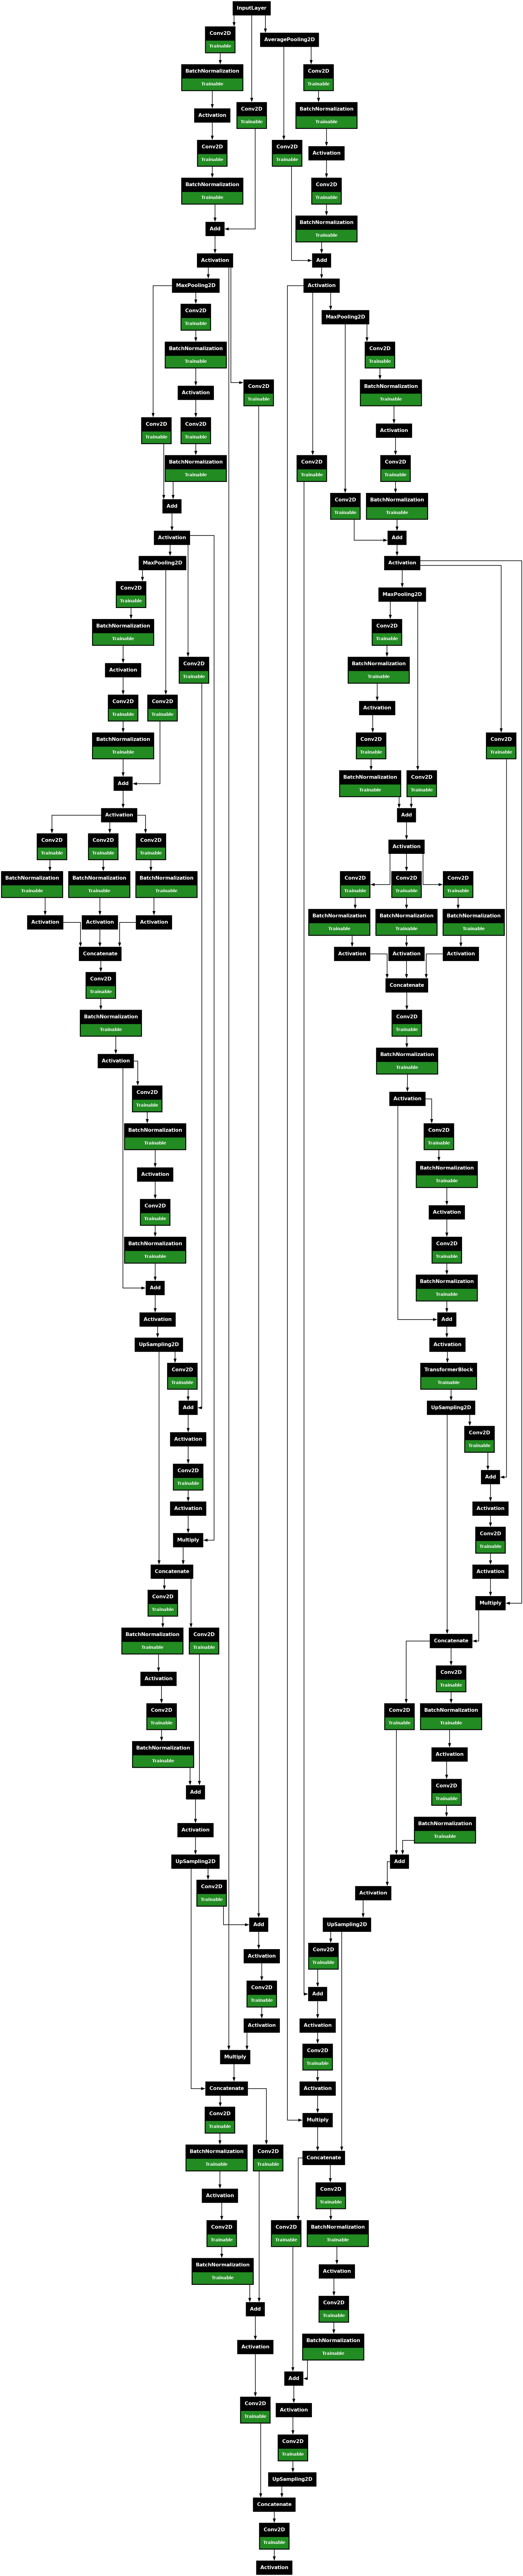

In [13]:
model = get_double_unet_with_transformer()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [14]:
# Compile with Weighted Multi-Scale Loss
model.compile(
    optimizer = "adam",
    loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8),
    metrics=['accuracy', MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

model.summary()

Model: "Double_UNet_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_pool1        │ (None, 32, 64, 1) │          0 │ input_layer[0][0] │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_2_conv1        │ (None, 32, 64,    │        640 │ global_pool1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_2_bn1          │ (None, 32, 64,    │        256 │ enc1_2_conv1[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_1_conv1        │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_2_act1         │ (None, 32, 64,    │          0 │ enc1_2_bn1[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_1_bn1          │ (None, 64, 128,   │        256 │ enc1_1_conv1[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_2_conv2        │ (None, 32, 64,    │     36,928 │ enc1_2_act1[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_1_act1         │ (None, 64, 128,   │          0 │ enc1_1_bn1[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_2_bn2          │ (None, 32, 64,    │        256 │ enc1_2_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_2_conv_skip    │ (None, 32, 64,    │        128 │ global_pool1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_1_conv2        │ (None, 64, 128,   │     36,928 │ enc1_1_act1[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_2_add (Add)    │ (None, 32, 64,    │          0 │ enc1_2_bn2[0][0], │
│                     │ 64)               │            │ enc1_2_conv_skip… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_1_bn2          │ (None, 64, 128,   │        256 │ enc1_1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_1_conv_skip    │ (None, 64, 128,   │        128 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_2_act2         │ (None, 32, 64,    │          0 │ enc1_2_add[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_1_add (Add)    │ (None, 64, 128,   │          0 │ enc1_1_bn2[0][0]

 Total params: 12,779,333 (48.75 MB)

 Trainable params: 12,768,069 (48.71 MB)

 Non-trainable params: 11,264 (44.00 KB)

In [15]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Select a specific image and mask from the dataset
sample_idx = 42
sample_image = X_train[sample_idx]
sample_mask = y_train[sample_idx]

# Initialize the VizCallback with the selected image and mask
viz_callback = VizCallback(
    image=sample_image,
    label=sample_mask,
    num_classes=num_classes,
    frequency=5
)

In [16]:
def scheduler(epoch):
    # Parametri
    warmup_epochs = 5  # Numero di epoche di warm-up
    plateau_epochs = 3  # Numero di epoche a learning rate costante
    initial_lr = 1e-3  # Learning rate iniziale
    min_lr = 1e-6  # Learning rate minimo
    total_epochs = 200  # Numero totale di epoche

    if epoch < warmup_epochs:
        # Fase di warm-up
        return float((epoch + 1) / warmup_epochs * initial_lr)
    elif epoch < warmup_epochs + plateau_epochs:
        # Fase di plateau
        return float(initial_lr)
    else:
        # Fase di cosine annealing
        return float(min_lr + 0.5 * (initial_lr - min_lr) *
                     (1 + tf.math.cos((epoch - warmup_epochs - plateau_epochs) /
                                      (total_epochs - warmup_epochs - plateau_epochs) * 3.14159)))


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

Epoch 1/200


I0000 00:00:1734106818.755450      73 service.cc:145] XLA service 0x79c124021250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734106818.755514      73 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734106818.755520      73 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734106842.439159     111 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_87', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:1734106842.551212     110 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_85', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:1734106851.456981     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1016 bytes spill stores, 1016 bytes spill loads

I0000 00:00

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.3850 - loss: 0.2996 - mean_iou: 0.2106

I0000 00:00:1734106950.587995     200 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_21', 1348 bytes spill stores, 1348 bytes spill loads

I0000 00:00:1734106955.367075     202 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 1016 bytes spill stores, 1016 bytes spill loads

I0000 00:00:1734106966.548749     202 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1016 bytes spill stores, 1016 bytes spill loads

I0000 00:00:1734106967.643121     203 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_86', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:1734106974.020839     201 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_87', 1384 bytes spill stores, 1384 bytes spill loads

I0000 00:00:17341069

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3866 - loss: 0.2985 - mean_iou: 0.2117   

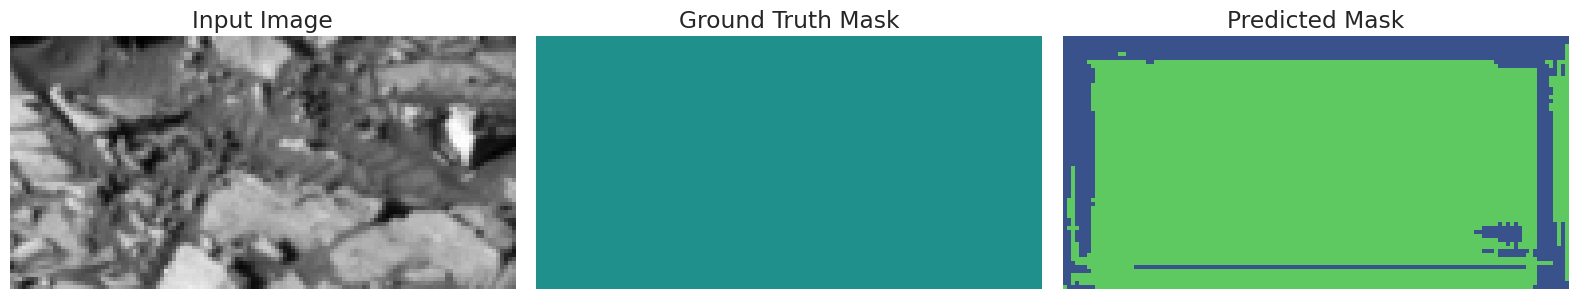

47/47 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.3881 - loss: 0.2975 - mean_iou: 0.2127 - val_accuracy: 0.2132 - val_loss: 0.3694 - val_mean_iou: 0.0947 - learning_rate: 2.0000e-04
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - accuracy: 0.4949 - loss: 0.2175 - mean_iou: 0.3710 - val_accuracy: 0.3176 - val_loss: 0.5379 - val_mean_iou: 0.1321 - learning_rate: 4.0000e-04
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - accuracy: 0.5285 - loss: 0.2095 - mean_iou: 0.3448 - val_accuracy: 0.3254 - val_loss: 0.7281 - val_mean_iou: 0.1253 - learning_rate: 6.0000e-04
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 410ms/step - accuracy: 0.5399 - loss: 0.2067 - mean_iou: 0.3624 - val_accuracy: 0.1830 - val_loss: 1.1896 - val_mean_iou: 0.0601 - learning_rate: 8.0000e-04
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - accuracy: 0.5584 - loss: 0.2062 - mean_iou: 0.4540 - val_accuracy: 0.1830 - val_loss: 0.9333 - val_mean_iou: 0.0601 - learning_rate: 0.0010
Epoch 6/200
47/47 

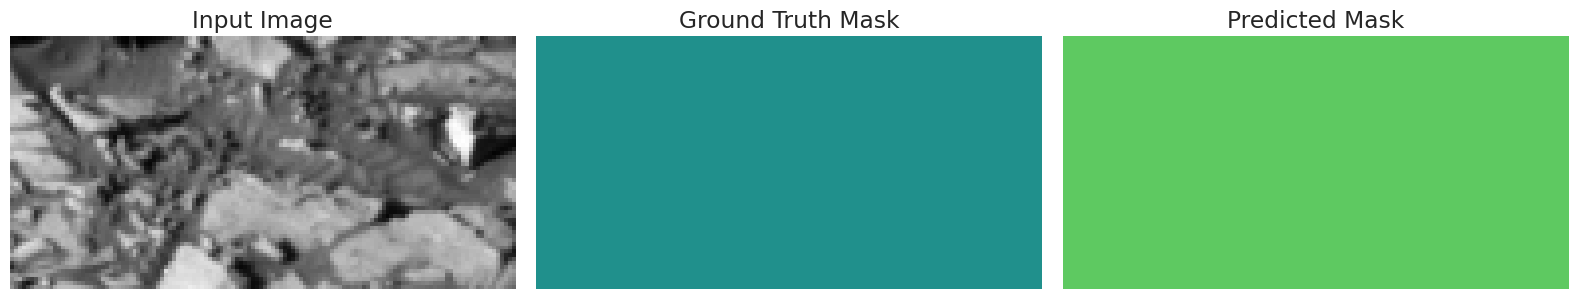

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 442ms/step - accuracy: 0.5692 - loss: 0.2003 - mean_iou: 0.4613 - val_accuracy: 0.1830 - val_loss: 0.8364 - val_mean_iou: 0.0601 - learning_rate: 0.0010
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 425ms/step - accuracy: 0.5885 - loss: 0.1969 - mean_iou: 0.4895 - val_accuracy: 0.1830 - val_loss: 0.9456 - val_mean_iou: 0.0601 - learning_rate: 0.0010
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - accuracy: 0.6181 - loss: 0.1911 - mean_iou: 0.5332 - val_accuracy: 0.2015 - val_loss: 0.8574 - val_mean_iou: 0.0752 - learning_rate: 0.0010
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.6021 - loss: 0.1947 - mean_iou: 0.5088 - val_accuracy: 0.2076 - val_loss: 0.6389 - val_mean_iou: 0.0803 - learning_rate: 0.0010
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - accuracy: 0.6100 - loss: 0.1902 - mean_iou: 0.5236 - val_accuracy: 0.3568 - val_loss: 0.4226 - val_mean_iou: 0.2135 - learning_rate: 9.9993e-04
Epoch 11/200
47/47 ━━━━━━━━

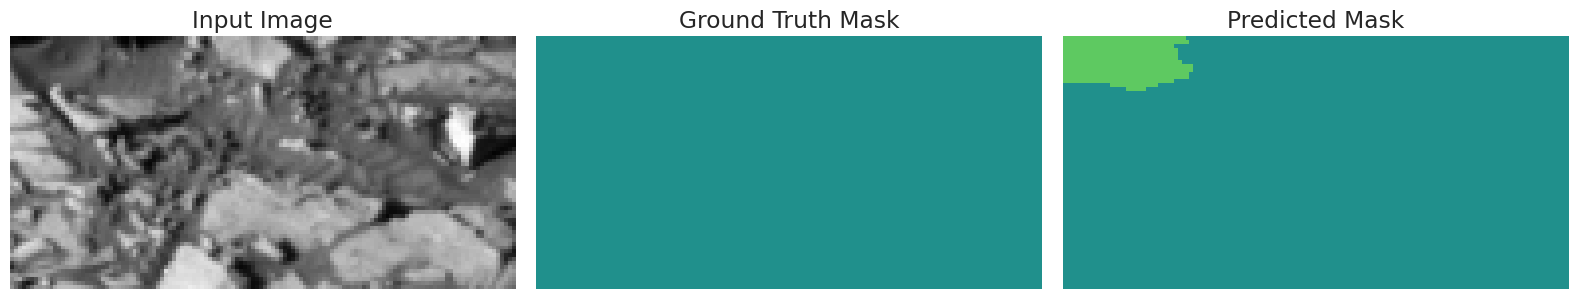

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - accuracy: 0.6345 - loss: 0.1852 - mean_iou: 0.5952 - val_accuracy: 0.3837 - val_loss: 0.3988 - val_mean_iou: 0.2482 - learning_rate: 9.9973e-04
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 425ms/step - accuracy: 0.6440 - loss: 0.1828 - mean_iou: 0.6122 - val_accuracy: 0.4625 - val_loss: 0.3123 - val_mean_iou: 0.3245 - learning_rate: 9.9940e-04
Epoch 13/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.6405 - loss: 0.1816 - mean_iou: 0.5967 - val_accuracy: 0.4003 - val_loss: 0.2996 - val_mean_iou: 0.2695 - learning_rate: 9.9893e-04
Epoch 14/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 422ms/step - accuracy: 0.6367 - loss: 0.1830 - mean_iou: 0.5617 - val_accuracy: 0.3628 - val_loss: 0.3250 - val_mean_iou: 0.2282 - learning_rate: 9.9833e-04
Epoch 15/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 424ms/step - accuracy: 0.6274 - loss: 0.1848 - mean_iou: 0.5469 - val_accuracy: 0.5431 - val_loss: 0.2160 - val_mean_iou: 0.4205 - learning_rate: 9.9759e-04
Epoch 16

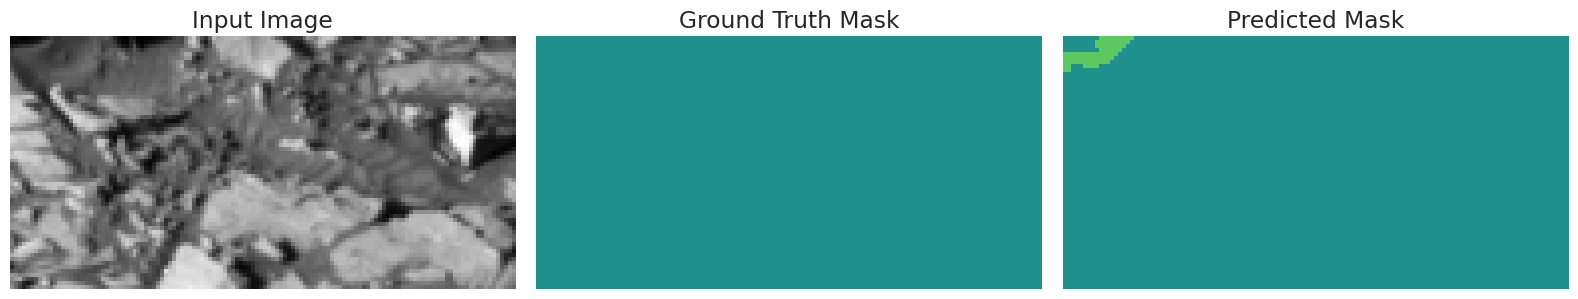

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.6450 - loss: 0.1798 - mean_iou: 0.5859 - val_accuracy: 0.5979 - val_loss: 0.2179 - val_mean_iou: 0.4873 - learning_rate: 9.9673e-04
Epoch 17/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.6504 - loss: 0.1778 - mean_iou: 0.6318 - val_accuracy: 0.5716 - val_loss: 0.2017 - val_mean_iou: 0.4529 - learning_rate: 9.9573e-04
Epoch 18/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.6589 - loss: 0.1760 - mean_iou: 0.6457 - val_accuracy: 0.5070 - val_loss: 0.2505 - val_mean_iou: 0.3782 - learning_rate: 9.9459e-04
Epoch 19/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - accuracy: 0.6622 - loss: 0.1752 - mean_iou: 0.6115 - val_accuracy: 0.4811 - val_loss: 0.2994 - val_mean_iou: 0.3581 - learning_rate: 9.9333e-04
Epoch 20/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - accuracy: 0.6408 - loss: 0.1808 - mean_iou: 0.5659 - val_accuracy: 0.5958 - val_loss: 0.2023 - val_mean_iou: 0.4977 - learning_rate: 9.9193e-04
Epoch 21

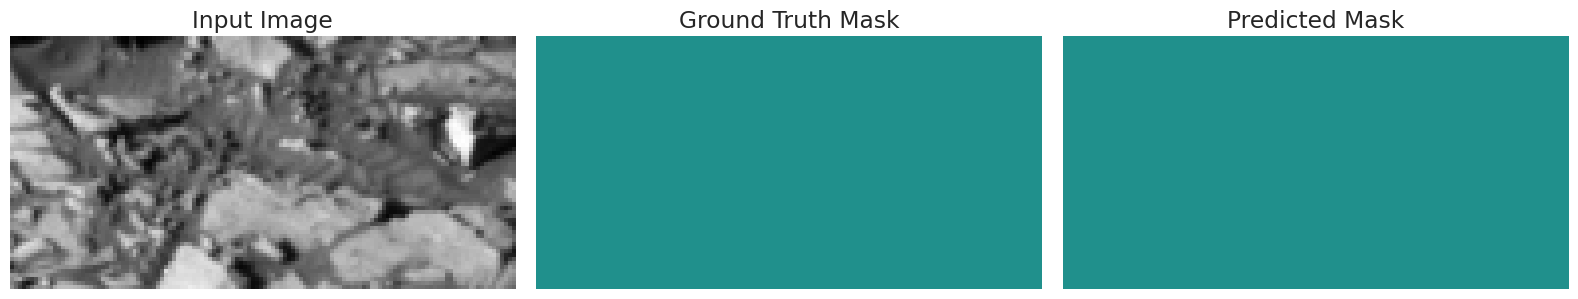

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.6400 - loss: 0.1827 - mean_iou: 0.6264 - val_accuracy: 0.4336 - val_loss: 0.3124 - val_mean_iou: 0.3020 - learning_rate: 9.9040e-04
Epoch 22/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.6487 - loss: 0.1785 - mean_iou: 0.6367
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0004943711683154106.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - accuracy: 0.6491 - loss: 0.1785 - mean_iou: 0.6367 - val_accuracy: 0.4327 - val_loss: 0.2750 - val_mean_iou: 0.3029 - learning_rate: 9.8874e-04
Epoch 23/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.6563 - loss: 0.1772 - mean_iou: 0.6849 - val_accuracy: 0.4604 - val_loss: 0.2689 - val_mean_iou: 0.3325 - learning_rate: 9.8695e-04
Epoch 24/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.6604 - loss: 0.1754 - mean_iou: 0.6868 - val_accuracy: 0.6362 - val_loss: 0.1891 - val_mean_iou: 0.5465 - learning_rate: 9.8503e-04
Epoch 25/200
47/47 ━━━━━━━━━━━━━━━━━━━

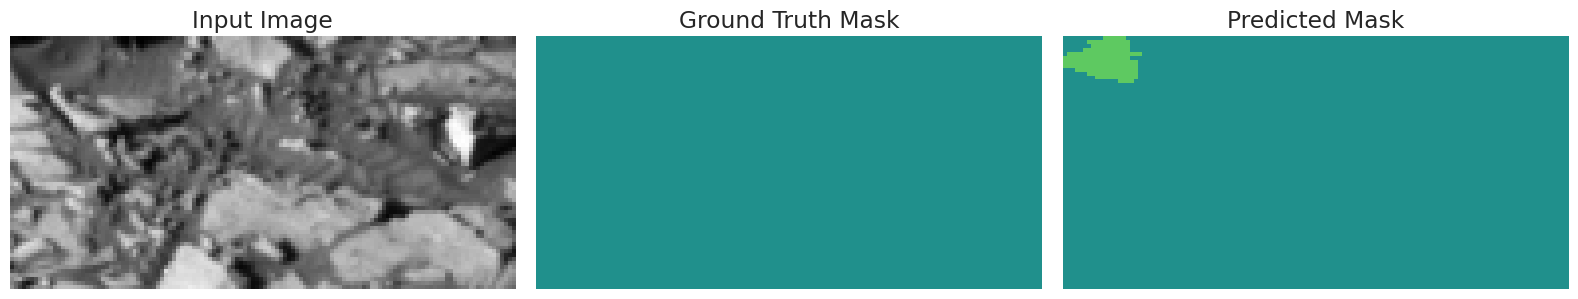

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.6549 - loss: 0.1762 - mean_iou: 0.6146 - val_accuracy: 0.6204 - val_loss: 0.1981 - val_mean_iou: 0.5219 - learning_rate: 9.8080e-04
Epoch 27/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.6759 - loss: 0.1707 - mean_iou: 0.7419 - val_accuracy: 0.6030 - val_loss: 0.2158 - val_mean_iou: 0.5100 - learning_rate: 9.7849e-04
Epoch 28/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 424ms/step - accuracy: 0.6642 - loss: 0.1729 - mean_iou: 0.6838 - val_accuracy: 0.5902 - val_loss: 0.2076 - val_mean_iou: 0.4701 - learning_rate: 9.7606e-04
Epoch 29/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.6770 - loss: 0.1706 - mean_iou: 0.7270
Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0004867458192165941.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 425ms/step - accuracy: 0.6773 - loss: 0.1706 - mean_iou: 0.7265 - val_accuracy: 0.6347 - val_loss: 0.1958 - val_mean_iou: 0.5500 - learning_rate: 9.7349e-04
Epoch 30/200
47/47 ━━━━━━━━━━━━━━━━━━━

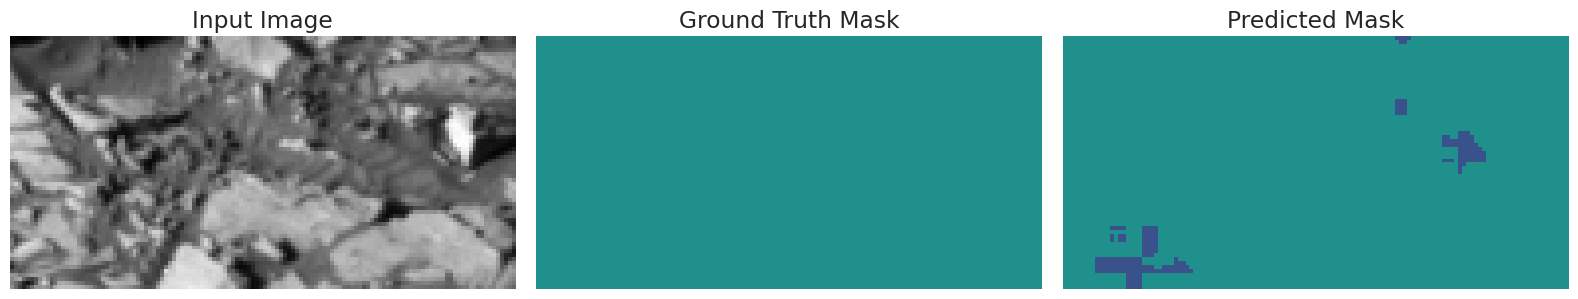

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.6870 - loss: 0.1676 - mean_iou: 0.7645 - val_accuracy: 0.5501 - val_loss: 0.2258 - val_mean_iou: 0.4296 - learning_rate: 9.6799e-04
Epoch 32/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.6855 - loss: 0.1679 - mean_iou: 0.7206 - val_accuracy: 0.6231 - val_loss: 0.1990 - val_mean_iou: 0.5370 - learning_rate: 9.6504e-04
Epoch 33/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 424ms/step - accuracy: 0.6888 - loss: 0.1672 - mean_iou: 0.7499 - val_accuracy: 0.6245 - val_loss: 0.1955 - val_mean_iou: 0.5294 - learning_rate: 9.6198e-04
Epoch 34/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.6929 - loss: 0.1652 - mean_iou: 0.7872
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.000479394308058545.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - accuracy: 0.6932 - loss: 0.1651 - mean_iou: 0.7865 - val_accuracy: 0.6079 - val_loss: 0.2051 - val_mean_iou: 0.5056 - learning_rate: 9.5879e-04
Epoch 35/200
47/47 ━━━━━━━━━━━━━━━━━━━━

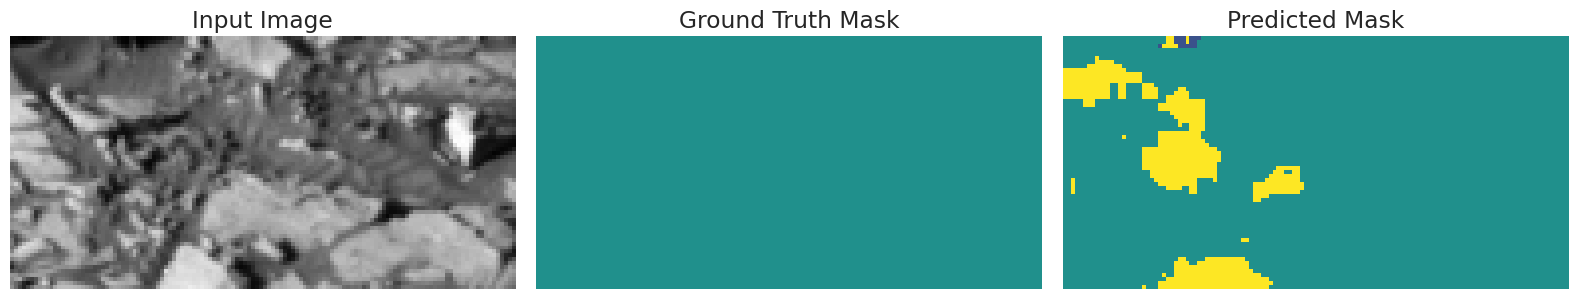

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 434ms/step - accuracy: 0.6834 - loss: 0.1679 - mean_iou: 0.7342 - val_accuracy: 0.5602 - val_loss: 0.2319 - val_mean_iou: 0.4678 - learning_rate: 9.5204e-04
Epoch 37/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.6906 - loss: 0.1654 - mean_iou: 0.7790 - val_accuracy: 0.6112 - val_loss: 0.2044 - val_mean_iou: 0.5180 - learning_rate: 9.4849e-04
Epoch 38/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.6916 - loss: 0.1644 - mean_iou: 0.7815 - val_accuracy: 0.4569 - val_loss: 0.3088 - val_mean_iou: 0.3314 - learning_rate: 9.4481e-04
Epoch 39/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6972 - loss: 0.1631 - mean_iou: 0.8057
Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0004705099272541702.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 422ms/step - accuracy: 0.6974 - loss: 0.1631 - mean_iou: 0.8050 - val_accuracy: 0.5551 - val_loss: 0.2452 - val_mean_iou: 0.4251 - learning_rate: 9.4102e-04
Epoch 40/200
47/47 ━━━━━━━━━━━━━━━━━━━

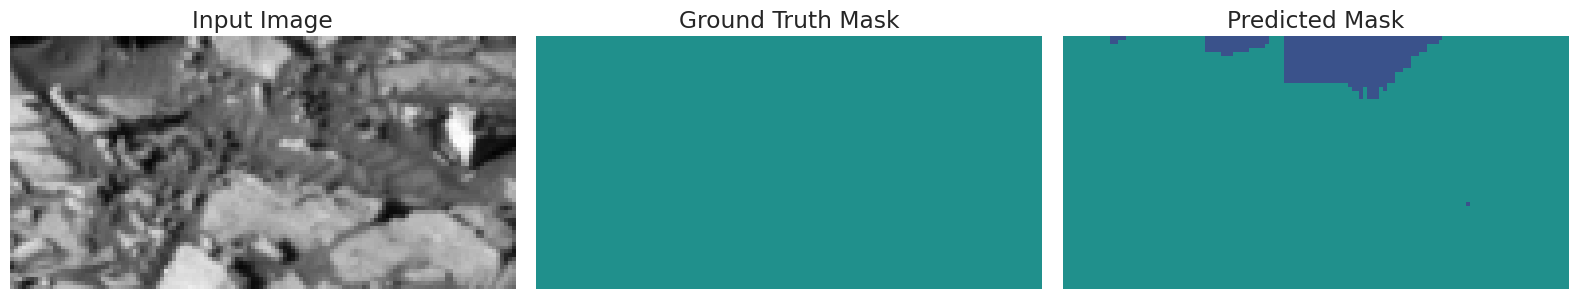

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.7072 - loss: 0.1599 - mean_iou: 0.8043 - val_accuracy: 0.6283 - val_loss: 0.2070 - val_mean_iou: 0.5284 - learning_rate: 9.3308e-04
Epoch 42/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.7007 - loss: 0.1624 - mean_iou: 0.7986 - val_accuracy: 0.5626 - val_loss: 0.2552 - val_mean_iou: 0.4265 - learning_rate: 9.2894e-04
Epoch 43/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 422ms/step - accuracy: 0.7027 - loss: 0.1616 - mean_iou: 0.7422 - val_accuracy: 0.6298 - val_loss: 0.2209 - val_mean_iou: 0.5376 - learning_rate: 9.2468e-04
Epoch 44/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7052 - loss: 0.1603 - mean_iou: 0.8174
Epoch 44: ReduceLROnPlateau reducing learning rate to 0.00046015207772143185.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.7055 - loss: 0.1602 - mean_iou: 0.8176 - val_accuracy: 0.6254 - val_loss: 0.2234 - val_mean_iou: 0.5321 - learning_rate: 9.2030e-04
Epoch 45/200
47/47 ━━━━━━━━━━━━━━━━━━

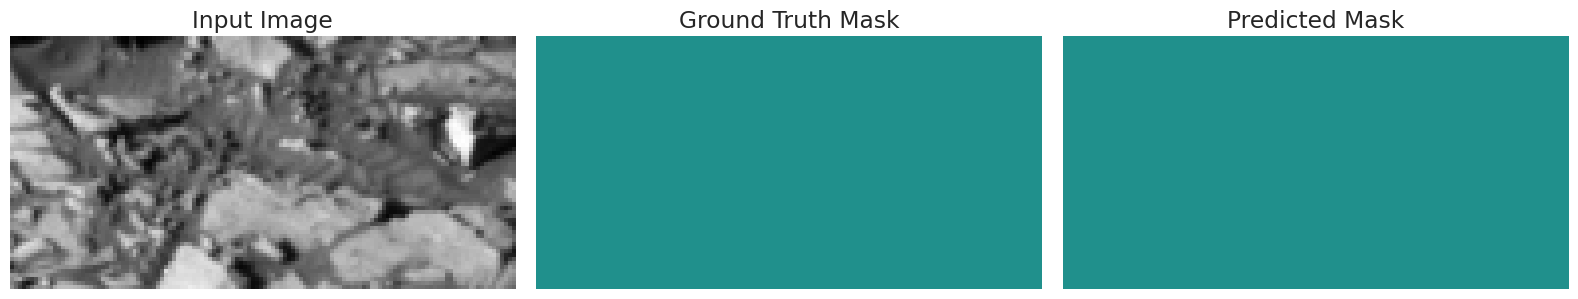

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7212 - loss: 0.1548 - mean_iou: 0.8753 - val_accuracy: 0.6253 - val_loss: 0.2151 - val_mean_iou: 0.5301 - learning_rate: 9.1122e-04
Epoch 47/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7222 - loss: 0.1547 - mean_iou: 0.8999 - val_accuracy: 0.6389 - val_loss: 0.2315 - val_mean_iou: 0.5546 - learning_rate: 9.0652e-04
Epoch 48/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.7282 - loss: 0.1528 - mean_iou: 0.9110 - val_accuracy: 0.6295 - val_loss: 0.2416 - val_mean_iou: 0.5405 - learning_rate: 9.0170e-04
Epoch 49/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7287 - loss: 0.1527 - mean_iou: 0.8934
Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0004483901138883084.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.7289 - loss: 0.1527 - mean_iou: 0.8936 - val_accuracy: 0.6631 - val_loss: 0.1988 - val_mean_iou: 0.5883 - learning_rate: 8.9678e-04
Epoch 50/200
47/47 ━━━━━━━━━━━━━━━━━━━

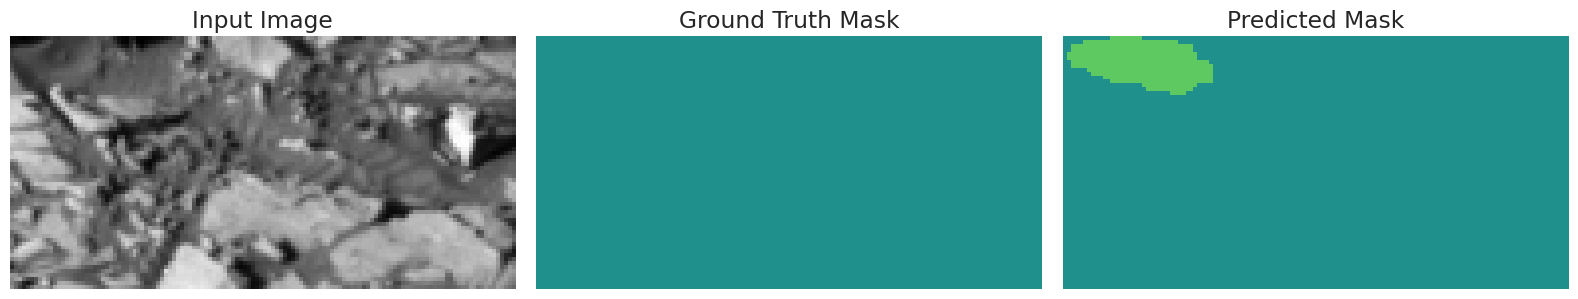

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 436ms/step - accuracy: 0.7146 - loss: 0.1308 - mean_iou: 0.7803 - val_accuracy: 0.5948 - val_loss: 0.2930 - val_mean_iou: 0.4774 - learning_rate: 8.8662e-04
Epoch 52/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - accuracy: 0.6555 - loss: 0.1280 - mean_iou: 0.5840 - val_accuracy: 0.5381 - val_loss: 0.2994 - val_mean_iou: 0.3960 - learning_rate: 8.8138e-04
Epoch 53/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.6635 - loss: 0.1202 - mean_iou: 0.5995 - val_accuracy: 0.3460 - val_loss: 0.7899 - val_mean_iou: 0.1207 - learning_rate: 8.7604e-04
Epoch 54/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.6415 - loss: 0.1242 - mean_iou: 0.5637
Epoch 54: ReduceLROnPlateau reducing learning rate to 0.00043530267430469394.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.6422 - loss: 0.1241 - mean_iou: 0.5644 - val_accuracy: 0.5003 - val_loss: 0.2256 - val_mean_iou: 0.3737 - learning_rate: 8.7061e-04
Epoch 55/200
47/47 ━━━━━━━━━━━━━━━━━━

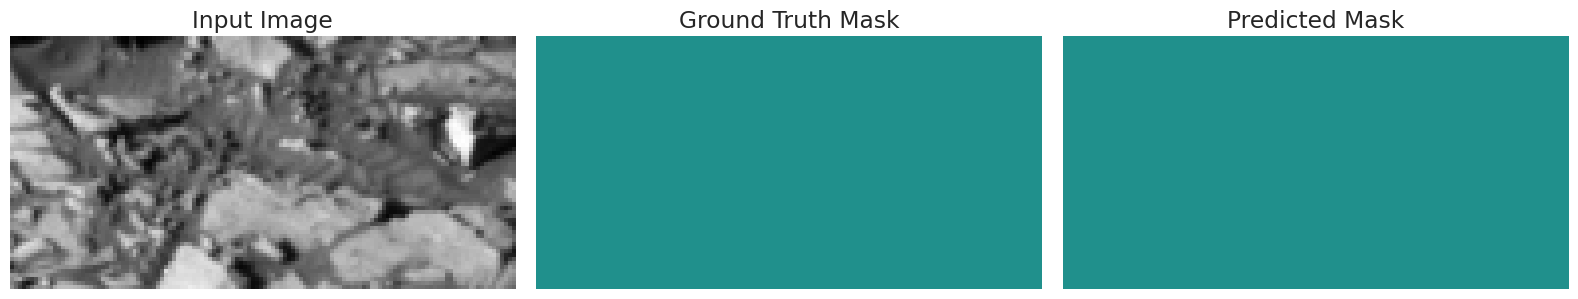

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.6732 - loss: 0.1151 - mean_iou: 0.6125 - val_accuracy: 0.4703 - val_loss: 0.2619 - val_mean_iou: 0.3490 - learning_rate: 8.5943e-04
Epoch 57/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.6647 - loss: 0.1322 - mean_iou: 0.5975 - val_accuracy: 0.4254 - val_loss: 0.2447 - val_mean_iou: 0.2918 - learning_rate: 8.5370e-04
Epoch 58/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.6763 - loss: 0.1154 - mean_iou: 0.6178 - val_accuracy: 0.4943 - val_loss: 0.1941 - val_mean_iou: 0.3669 - learning_rate: 8.4787e-04
Epoch 59/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.6987 - loss: 0.1070 - mean_iou: 0.6574 - val_accuracy: 0.6533 - val_loss: 0.1396 - val_mean_iou: 0.5598 - learning_rate: 8.4195e-04
Epoch 60/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - accuracy: 0.7023 - loss: 0.1032 - mean_iou: 0.6647 - val_accuracy: 0.6544 - val_loss: 0.1448 - val_mean_iou: 0.5653 - learning_rate: 8.3594e-04
Epoch 61

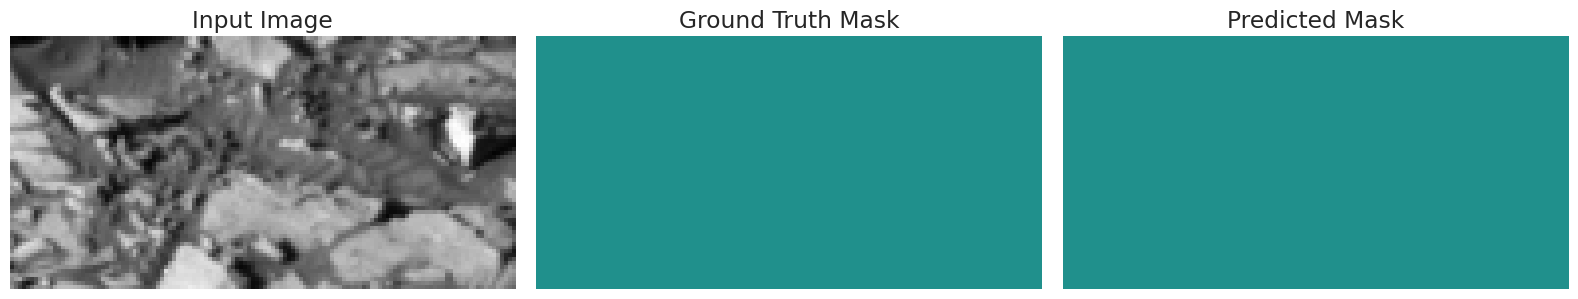

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7117 - loss: 0.0991 - mean_iou: 0.6816 - val_accuracy: 0.6381 - val_loss: 0.1532 - val_mean_iou: 0.5357 - learning_rate: 8.2984e-04
Epoch 62/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7054 - loss: 0.1021 - mean_iou: 0.6697 - val_accuracy: 0.6471 - val_loss: 0.1492 - val_mean_iou: 0.5549 - learning_rate: 8.2365e-04
Epoch 63/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7110 - loss: 0.1015 - mean_iou: 0.6803 - val_accuracy: 0.6282 - val_loss: 0.1678 - val_mean_iou: 0.5333 - learning_rate: 8.1738e-04
Epoch 64/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - accuracy: 0.7091 - loss: 0.1014 - mean_iou: 0.6762 - val_accuracy: 0.6739 - val_loss: 0.1356 - val_mean_iou: 0.5949 - learning_rate: 8.1102e-04
Epoch 65/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.7216 - loss: 0.0954 - mean_iou: 0.6998 - val_accuracy: 0.6428 - val_loss: 0.1528 - val_mean_iou: 0.5430 - learning_rate: 8.0458e-04
Epoch 66

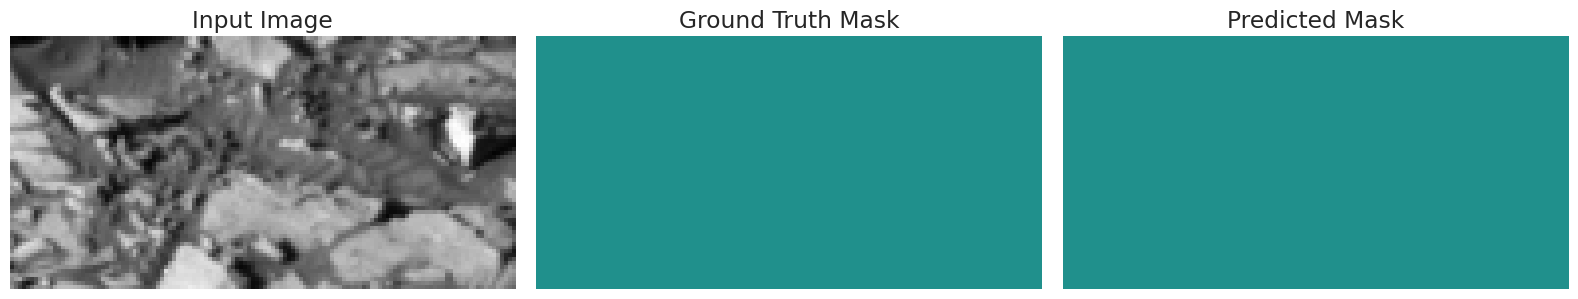

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.7184 - loss: 0.0963 - mean_iou: 0.6940 - val_accuracy: 0.6616 - val_loss: 0.1501 - val_mean_iou: 0.5754 - learning_rate: 7.9805e-04
Epoch 67/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7202 - loss: 0.0934 - mean_iou: 0.6971 - val_accuracy: 0.6049 - val_loss: 0.2067 - val_mean_iou: 0.4822 - learning_rate: 7.9145e-04
Epoch 68/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7159 - loss: 0.0953 - mean_iou: 0.6890 - val_accuracy: 0.6592 - val_loss: 0.1592 - val_mean_iou: 0.5675 - learning_rate: 7.8477e-04
Epoch 69/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7192 - loss: 0.0944 - mean_iou: 0.6957
Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0003890038642566651.
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.7196 - loss: 0.0943 - mean_iou: 0.6959 - val_accuracy: 0.6725 - val_loss: 0.1460 - val_mean_iou: 0.5942 - learning_rate: 7.7801e-04
Epoch 70/200
47/47 ━━━━━━━━━━━━━━━━━━━

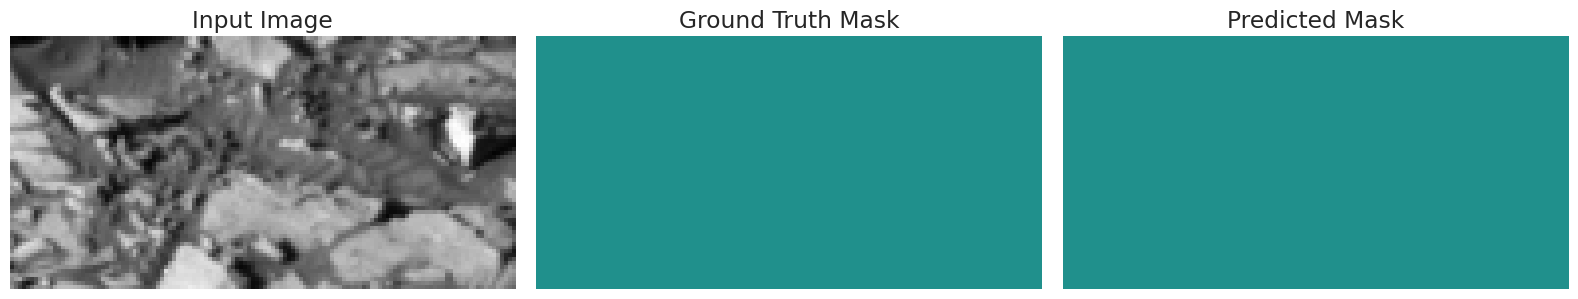

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.7236 - loss: 0.0933 - mean_iou: 0.7035 - val_accuracy: 0.6390 - val_loss: 0.1742 - val_mean_iou: 0.5361 - learning_rate: 7.6427e-04
Epoch 72/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - accuracy: 0.7226 - loss: 0.0932 - mean_iou: 0.7020 - val_accuracy: 0.6496 - val_loss: 0.1690 - val_mean_iou: 0.5507 - learning_rate: 7.5729e-04
Epoch 73/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.6953 - loss: 0.1098 - mean_iou: 0.6521 - val_accuracy: 0.5009 - val_loss: 0.3331 - val_mean_iou: 0.3451 - learning_rate: 7.5025e-04
Epoch 74/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.7005 - loss: 0.1012 - mean_iou: 0.6613
Epoch 74: ReduceLROnPlateau reducing learning rate to 0.00037156965117901564.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.7009 - loss: 0.1011 - mean_iou: 0.6616 - val_accuracy: 0.6225 - val_loss: 0.1763 - val_mean_iou: 0.5206 - learning_rate: 7.4314e-04
Epoch 75/200
47/47 ━━━━━━━━━━━━━━━━━━

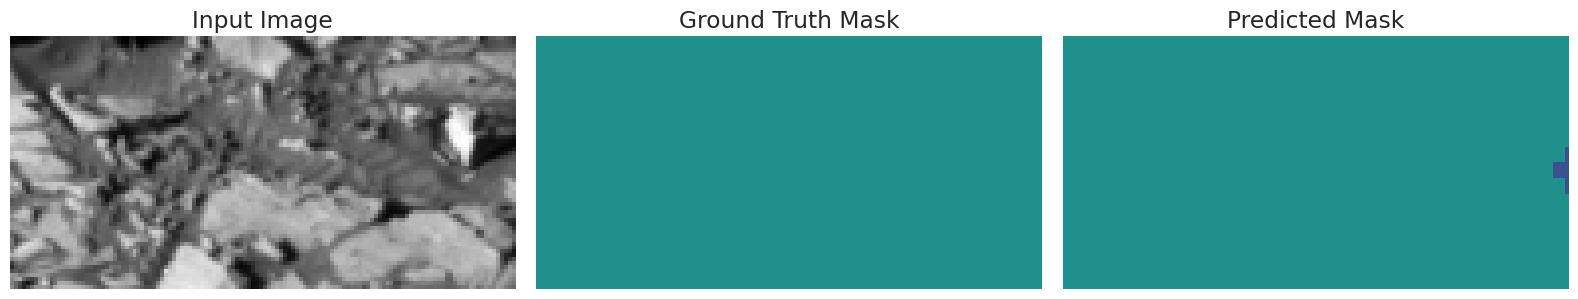

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.6931 - loss: 0.1077 - mean_iou: 0.6475 - val_accuracy: 0.4609 - val_loss: 0.3095 - val_mean_iou: 0.3179 - learning_rate: 7.2872e-04
Epoch 77/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.7005 - loss: 0.1093 - mean_iou: 0.6597 - val_accuracy: 0.5015 - val_loss: 0.2739 - val_mean_iou: 0.3719 - learning_rate: 7.2142e-04
Epoch 78/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7069 - loss: 0.1001 - mean_iou: 0.6722 - val_accuracy: 0.6511 - val_loss: 0.1547 - val_mean_iou: 0.5605 - learning_rate: 7.1406e-04
Epoch 79/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7066 - loss: 0.1068 - mean_iou: 0.6727
Epoch 79: ReduceLROnPlateau reducing learning rate to 0.00035332381958141923.
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.7069 - loss: 0.1067 - mean_iou: 0.6727 - val_accuracy: 0.6018 - val_loss: 0.1927 - val_mean_iou: 0.4880 - learning_rate: 7.0665e-04
Epoch 80/200
47/47 ━━━━━━━━━━━━━━━━━━

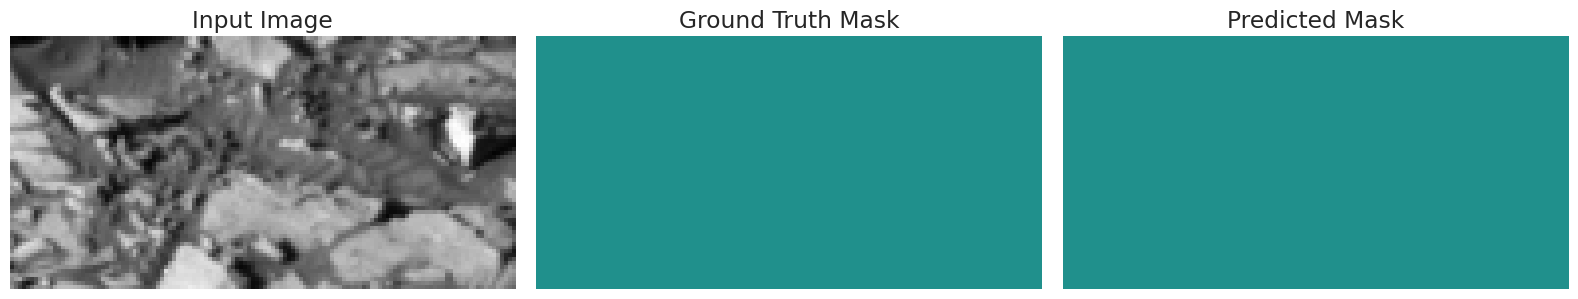

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 444ms/step - accuracy: 0.7174 - loss: 0.0954 - mean_iou: 0.6919 - val_accuracy: 0.5875 - val_loss: 0.2348 - val_mean_iou: 0.4945 - learning_rate: 6.9165e-04
Epoch 82/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.7313 - loss: 0.0887 - mean_iou: 0.7189 - val_accuracy: 0.6545 - val_loss: 0.1877 - val_mean_iou: 0.5647 - learning_rate: 6.8407e-04
Epoch 83/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.7284 - loss: 0.0908 - mean_iou: 0.7132 - val_accuracy: 0.6618 - val_loss: 0.1713 - val_mean_iou: 0.5766 - learning_rate: 6.7645e-04
Epoch 84/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7304 - loss: 0.0897 - mean_iou: 0.7175
Epoch 84: ReduceLROnPlateau reducing learning rate to 0.00033438848913647234.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.7307 - loss: 0.0897 - mean_iou: 0.7175 - val_accuracy: 0.6631 - val_loss: 0.1599 - val_mean_iou: 0.5751 - learning_rate: 6.6878e-04


In [17]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping, reduce_lr, viz_callback],
    verbose=1
).history

In [18]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_4_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 59.49%


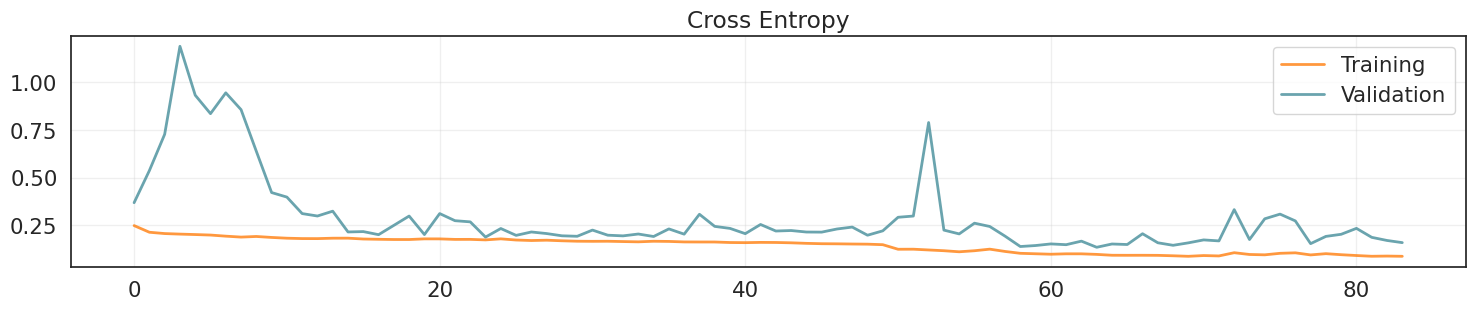

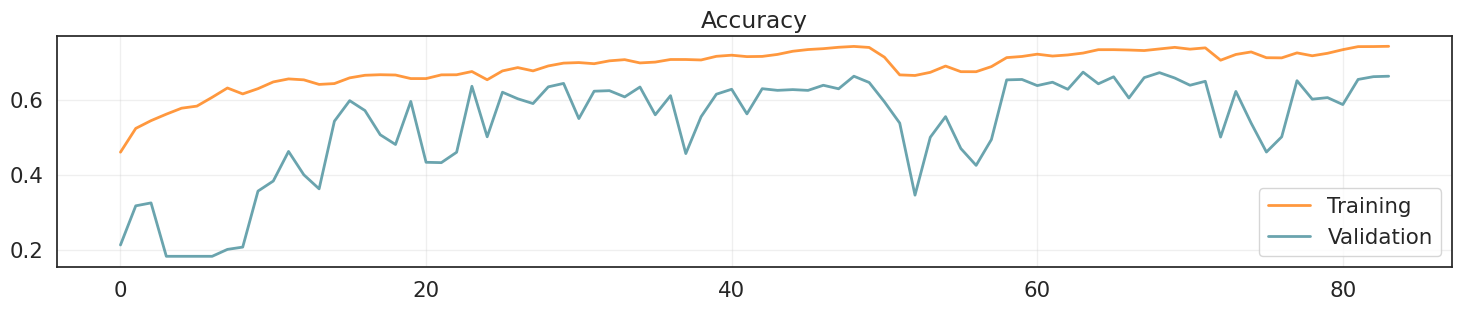

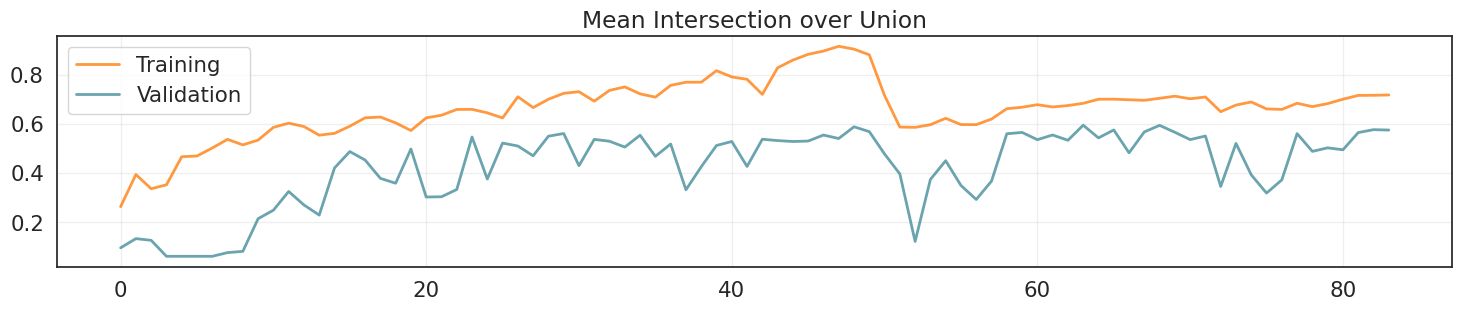

In [19]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [22]:
# path
model_path = "/kaggle/working/UNet_4_59.49.keras"

# Create a dictionary mapping the names of custom layers to their classes/functions
custom_objects = {
    'TransformerBlock': TransformerBlock,
}

# Load the model
try:
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully.


In [23]:
model.compile(optimizer="adam",
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8),
              metrics=["accuracy",
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])

In [24]:
test_loss, test_accuracy, test_mean_iou = model.evaluate(X_our_test, y_our_test, verbose=1)
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}\nMean Over Union: {test_mean_iou}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 353ms/step - accuracy: 0.6515 - loss: 0.1417 - mean_iou: 0.5918
Loss: 0.1440906971693039
Accuracy: 0.6614230275154114
Mean Over Union: 0.595128059387207


In [25]:
def calculate_class_iou(y_true, y_pred, num_classes):
    class_iou = {}

    for class_idx in range(num_classes):
        # Crea una maschera binaria per la classe
        true_mask = (y_true == class_idx).astype(int)
        pred_mask = (y_pred == class_idx).astype(int)

        # Calcola l'intersezione e l'unione
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Calcola IoU, evitando la divisione per zero
        iou = intersection / union if union > 0 else 0.0
        class_iou[class_idx] = iou

    return class_iou

In [26]:
# Compute the prediction
y_pred = model.predict(X_our_test, batch_size=10)
y_pred_labels = tf.math.argmax(y_pred, axis=-1).numpy()

# Compute IoU per class
iou_per_class = calculate_class_iou(y_our_test, y_pred_labels, num_classes)

# Print the results
for class_idx, iou in iou_per_class.items():
    print(f"Class {class_idx}: IoU = {round(iou, 4)}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step
Class 0: IoU = 0.0
Class 1: IoU = 0.6942
Class 2: IoU = 0.5547
Class 3: IoU = 0.5619
Class 4: IoU = 0.0


In [27]:
def calculate_metrics_per_class(y_true, y_pred, num_classes):
    metrics = {}

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        true_binary = (y_true == class_idx).flatten()
        pred_binary = (y_pred == class_idx).flatten()

        # Compute precision, recall, and F1-score
        precision = precision_score(true_binary, pred_binary, zero_division=0)
        recall = recall_score(true_binary, pred_binary, zero_division=0)
        f1 = f1_score(true_binary, pred_binary, zero_division=0)

        # Store the metrics for the current class
        metrics[class_idx] = {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }

    return metrics

In [28]:
# Compute metrics for each class
metrics_per_class = calculate_metrics_per_class(y_our_test, y_pred_labels, num_classes)

# Print the results for each class
for class_idx, metrics in metrics_per_class.items():
    print(f"Class {class_idx}:")
    print(f"  Precision = {round(metrics['Precision'], 4)}")
    print(f"  Recall = {round(metrics['Recall'], 4)}")
    print(f"  F1-score = {round(metrics['F1-score'], 4)}")

Class 0:
  Precision = 0.0
  Recall = 0.0
  F1-score = 0.0
Class 1:
  Precision = 0.7756
  Recall = 0.8687
  F1-score = 0.8195
Class 2:
  Precision = 0.5982
  Recall = 0.8841
  F1-score = 0.7135
Class 3:
  Precision = 0.586
  Recall = 0.9317
  F1-score = 0.7195
Class 4:
  Precision = 0.0
  Recall = 0.0
  F1-score = 0.0


## 📊 Prepare Your Submission


In [29]:
# Percorso del file del modello
model_path = "/kaggle/working/UNet_4_59.49.keras"

# Carica il modello
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [30]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 58s 176ms/step
Predictions shape: (10022, 64, 128)


In [31]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [32]:
# Create and save the CSV submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)  # Convert predictions to DataFrame
submission_df.to_csv(f"/kaggle/working/{submission_filename}", index=False)

print(f"Submission file saved: {submission_filename}")

Submission file saved: submission_UNet_4_59.49.csv
